In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from tensorflow.python.ops.numpy_ops import np_config
from google.colab import drive
from pathlib import Path
import tensorflow_datasets as tfds
from datetime import datetime
from math import ceil
drive.mount('/content/drive')
data_path = Path('drive/MyDrive/ZPS')
np_config.enable_numpy_behavior()

Mounted at /content/drive


# Dataset

Data was generated in numerical simulations and saved in the .root format. It was then converted to the .tfrecord file using the `ROOT_to_TFRecord.ipynb` notebook - with conversion_uvwt function.

In this notebook, the approach of reconstructing by projection is implemented. This means that the model makes predictions independently for each projection (U, V, W).

The data in the .tfrecord file has a batch size of 3. The shape of the images is (3, 256, 512), and the shape of the targets is (3, 6). Each example in a batch represents a different projection of the same event.

In [2]:
train_files = [data_path / 'simulated_data' / 'data_resnet'  / f"out_random_sigma-001-part-{i}.tfrecord" for i in range(4)]
val_files = [data_path / 'simulated_data' / 'data_resnet'  / f"out_random_sigma-001-part-{i}.tfrecord" for i in [4]]
test_files = [data_path / 'simulated_data' / 'data_resnet'  / f"out_random_sigma-part-{i}.tfrecord" for i in range(5)]
batch_size = 64
train_dataset = tf.data.TFRecordDataset(train_files, compression_type='GZIP', num_parallel_reads=5)
test_dataset = tf.data.TFRecordDataset(test_files, compression_type='GZIP', num_parallel_reads=5)
val_dataset = tf.data.TFRecordDataset(val_files, compression_type='GZIP', num_parallel_reads=5)
# Create a description of the features.
feature_description = {
    'myChargeArray': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string),
}

def _parse_function(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    charge, target = parsed_features['myChargeArray'], parsed_features['target']
    charge = tf.io.parse_tensor(charge, tf.float64)
    target = tf.io.parse_tensor(target, tf.float64)
    charge = tf.expand_dims(charge, -1)
    return charge, target


def prepare_dataset(dataset, batch_size):
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.unbatch()
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset = prepare_dataset(train_dataset, batch_size)
test_dataset = prepare_dataset(test_dataset, batch_size = 3)
val_dataset = prepare_dataset(val_dataset, batch_size)

## Visualization

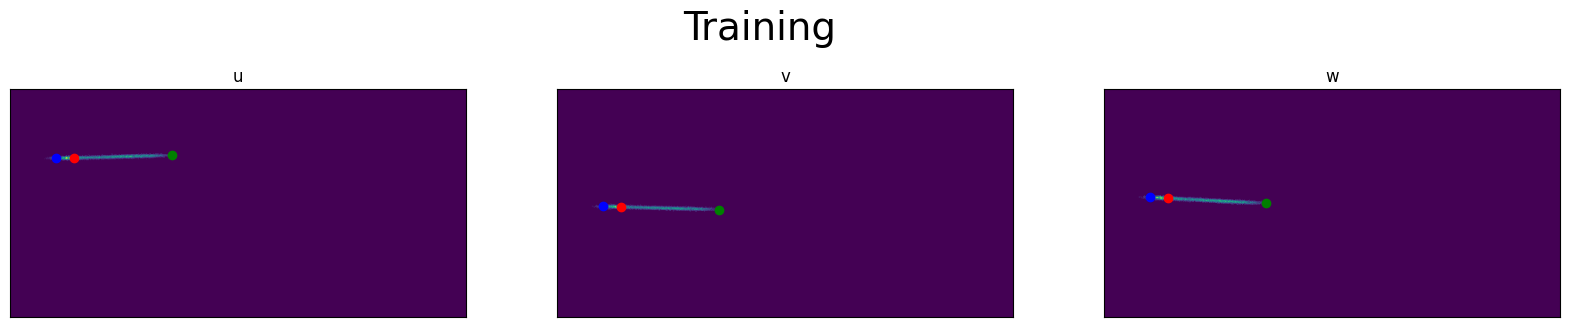

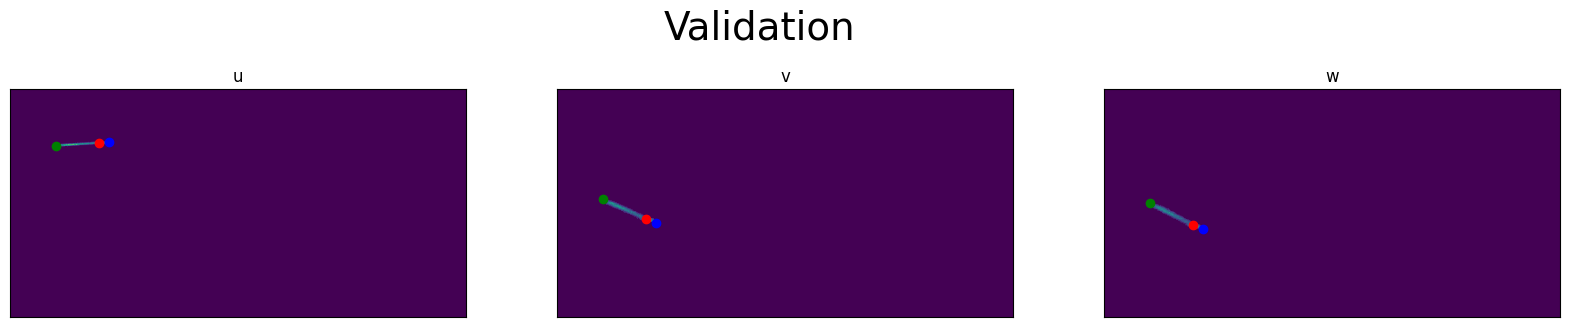

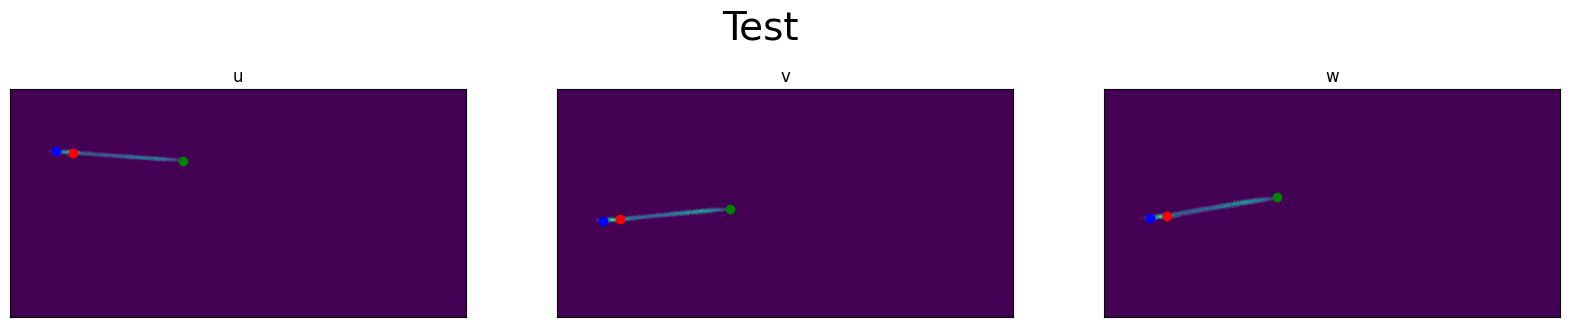

In [3]:
def view_images(datasets, dataset_names):
    batchSize = 3
    cols = 3

    for i, ds in enumerate(datasets):
        image, keypoints = next(iter(ds))
        keypoints = keypoints.reshape(-1, 3, 2)

        fig = plt.figure(figsize=(20, 4))
        fig.suptitle(dataset_names[i], fontsize=28)
        labels = {0:"u", 1:"v", 2:"w"}
        for idx in range(batchSize):
            ax = fig.add_subplot(1, cols, idx+1, xticks=[], yticks=[])
            ax.imshow(image[idx, : , :, 0])
            ax.set_title(labels[idx%3])
            ax.scatter(keypoints[idx, 0, 0], keypoints[idx, 0, 1], c = 'r')
            ax.scatter(keypoints[idx, 1, 0], keypoints[idx, 1, 1], c = 'g')
            ax.scatter(keypoints[idx, 2, 0], keypoints[idx, 2, 1], c = 'b')


view_images([train_dataset, val_dataset, test_dataset], ['Training', 'Validation', 'Test'])

# Train

## Create Model

In [ ]:
from tensorflow.keras import regularizers

regularizer = regularizers.l2(0.01)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 5, padding='same', activation='relu', data_format="channels_last", input_shape=(256, 512, 1), kernel_regularizer=regularizer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu', data_format="channels_last", kernel_regularizer=regularizer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(64, 5, padding='same', activation='relu', data_format="channels_last", kernel_regularizer=regularizer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizer),
    tf.keras.layers.Dense(6)
])

model.build()
model.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = [tf.keras.metrics.MeanSquaredError(name='mse')]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 512, 16)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 256, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 256, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 256, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 128, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64, 128, 32)       0

In [ ]:
log_dir = data_path / "logs" / 'uwvt' / f"model-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    profile_batch=(10, 20)
)
checkpoint = ModelCheckpoint(
    filepath = str(log_dir / 'model-{epoch:03d}.h5'),
    verbose=1,
    monitor='val_mse',
    save_best_only=True,
    mode='min'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_mse",
    mode = 'min',
    patience=4,
    restore_best_weights=True
)

## Train Model

In [ ]:
model_history = model.fit(
    train_dataset,
    epochs = 10,
    workers = 4,
    validation_data = val_dataset.take(50),
    callbacks = [early_stopping, checkpoint, tensorboard_callback]
)

Epoch 1/10
   3751/Unknown - 1093s 288ms/step - loss: 743.2363 - mse: 689.8920
Epoch 1: val_mse improved from inf to 1054.76709, saving model to drive/MyDrive/ZPS/logs/uwvt/model-20231220-061247/model-001.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3751/3751 [==============================] - 1113s 294ms/step - loss: 743.2363 - mse: 689.8920 - val_loss: 1119.6915 - val_mse: 1054.7671
Epoch 2/10
3751/3751 [==============================] - ETA: 0s - loss: 340.8122 - mse: 276.7170
Epoch 2: val_mse did not improve from 1054.76709
3751/3751 [==============================] - 1084s 289ms/step - loss: 340.8122 - mse: 276.7170 - val_loss: 1706.0526 - val_mse: 1648.3501
Epoch 3/10
3751/3751 [==============================] - ETA: 0s - loss: 242.1806 - mse: 187.1942
Epoch 3: val_mse did not improve from 1054.76709
3751/3751 [==============================] - 1085s 289ms/step - loss: 242.1806 - mse: 187.1942 - val_loss: 1677.5122 - val_mse: 1627.1764
Epoch 4/10
1839/3751 [=============>................] - ETA: 9:00 - loss: 197.1190 - mse: 148.1386

In [ ]:
model_history = model_history.history

In [ ]:
plt.plot(model_history['val_mse'])
plt.plot(model_history['mse'])
plt.legend(['val_mse','mse'])
plt.title("MSE")
plt.savefig(log_dir / "MSE.png")

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir drive/MyDrive/ZPS/logs/uwvt/model-20231211-061951

# Making Predictions

In [4]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

model_path = 'drive/MyDrive/ZPS/logs/uwvt/model-20231220-061247/model-001.h5'
model = load_model(model_path)

In [5]:
checkpoints = []
predicted = []
images = []
for image, checkpoint in test_dataset.take(100):
  images.append(image)
  predicted.append(model(image))
  checkpoints.append(checkpoint)

checkpoints = np.stack(checkpoints, axis = 0)
predicted = np.stack(predicted, axis = 0)
images = np.stack(images, axis = 0)

In [6]:
columns = ['Event_time_', 'Event_pos_', 'C_time_', 'C_pos_', 'Alpha_time_', 'Alpha_pos_']
df_real = pd.DataFrame()
df_predicted = pd.DataFrame()
for index, name in enumerate(['u', 'v', 'w']):
  col_names = [col + name for col in columns]
  df_real[col_names] = checkpoints[:, index, :]
  df_predicted[col_names] = predicted[:, index, :]

## Model's errors

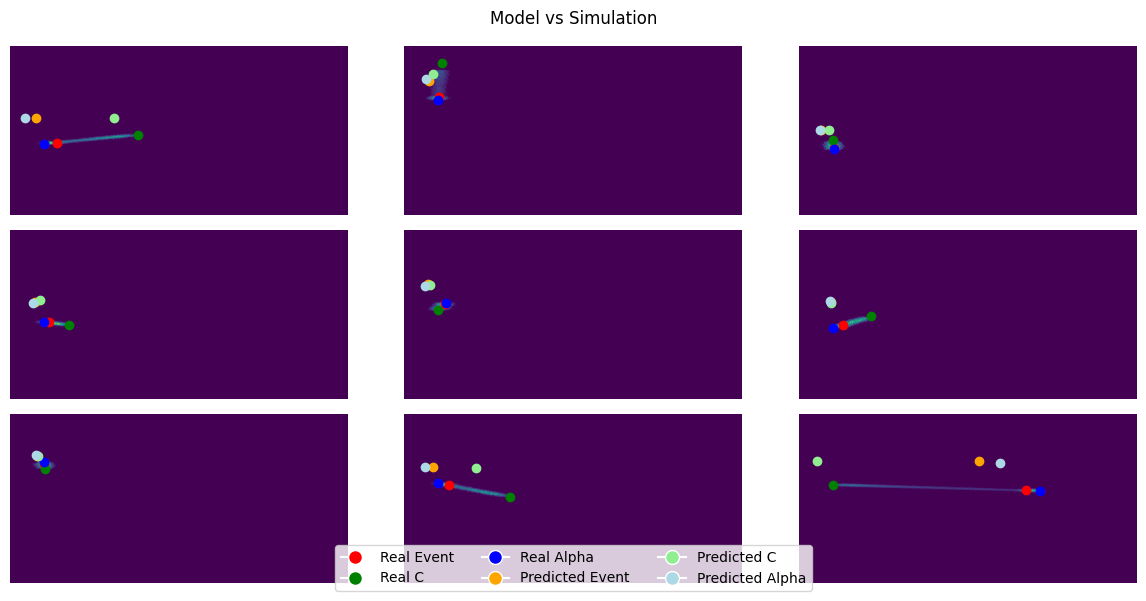

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(12, 6))
fig.suptitle("Model vs Simulation")
for index, ax in enumerate(axs.flat):
    ax.imshow(images[index, 1, :, :, 0])

    # Real data
    ax.scatter(df_real['Event_time_v'].iloc[index], df_real['Event_pos_v'].iloc[index], c='r')
    ax.scatter(df_real['C_time_v'].iloc[index], df_real['C_pos_v'].iloc[index], c='g')
    ax.scatter(df_real['Alpha_time_v'].iloc[index], df_real['Alpha_pos_v'].iloc[index], c='b')

    # Predicted data
    ax.scatter(df_predicted['Event_time_v'].iloc[index], df_predicted['Event_pos_v'].iloc[index], c='orange')
    ax.scatter(df_predicted['C_time_v'].iloc[index], df_predicted['C_pos_v'].iloc[index], c='lightgreen')
    ax.scatter(df_predicted['Alpha_time_v'].iloc[index], df_predicted['Alpha_pos_v'].iloc[index], c='lightblue')

    ax.axis('off')  # Turning off the axis


legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Real Event'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='Real C'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='Real Alpha'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Predicted Event'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=10, label='Predicted C'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Predicted Alpha')
]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=3)
plt.tight_layout()
plt.show()

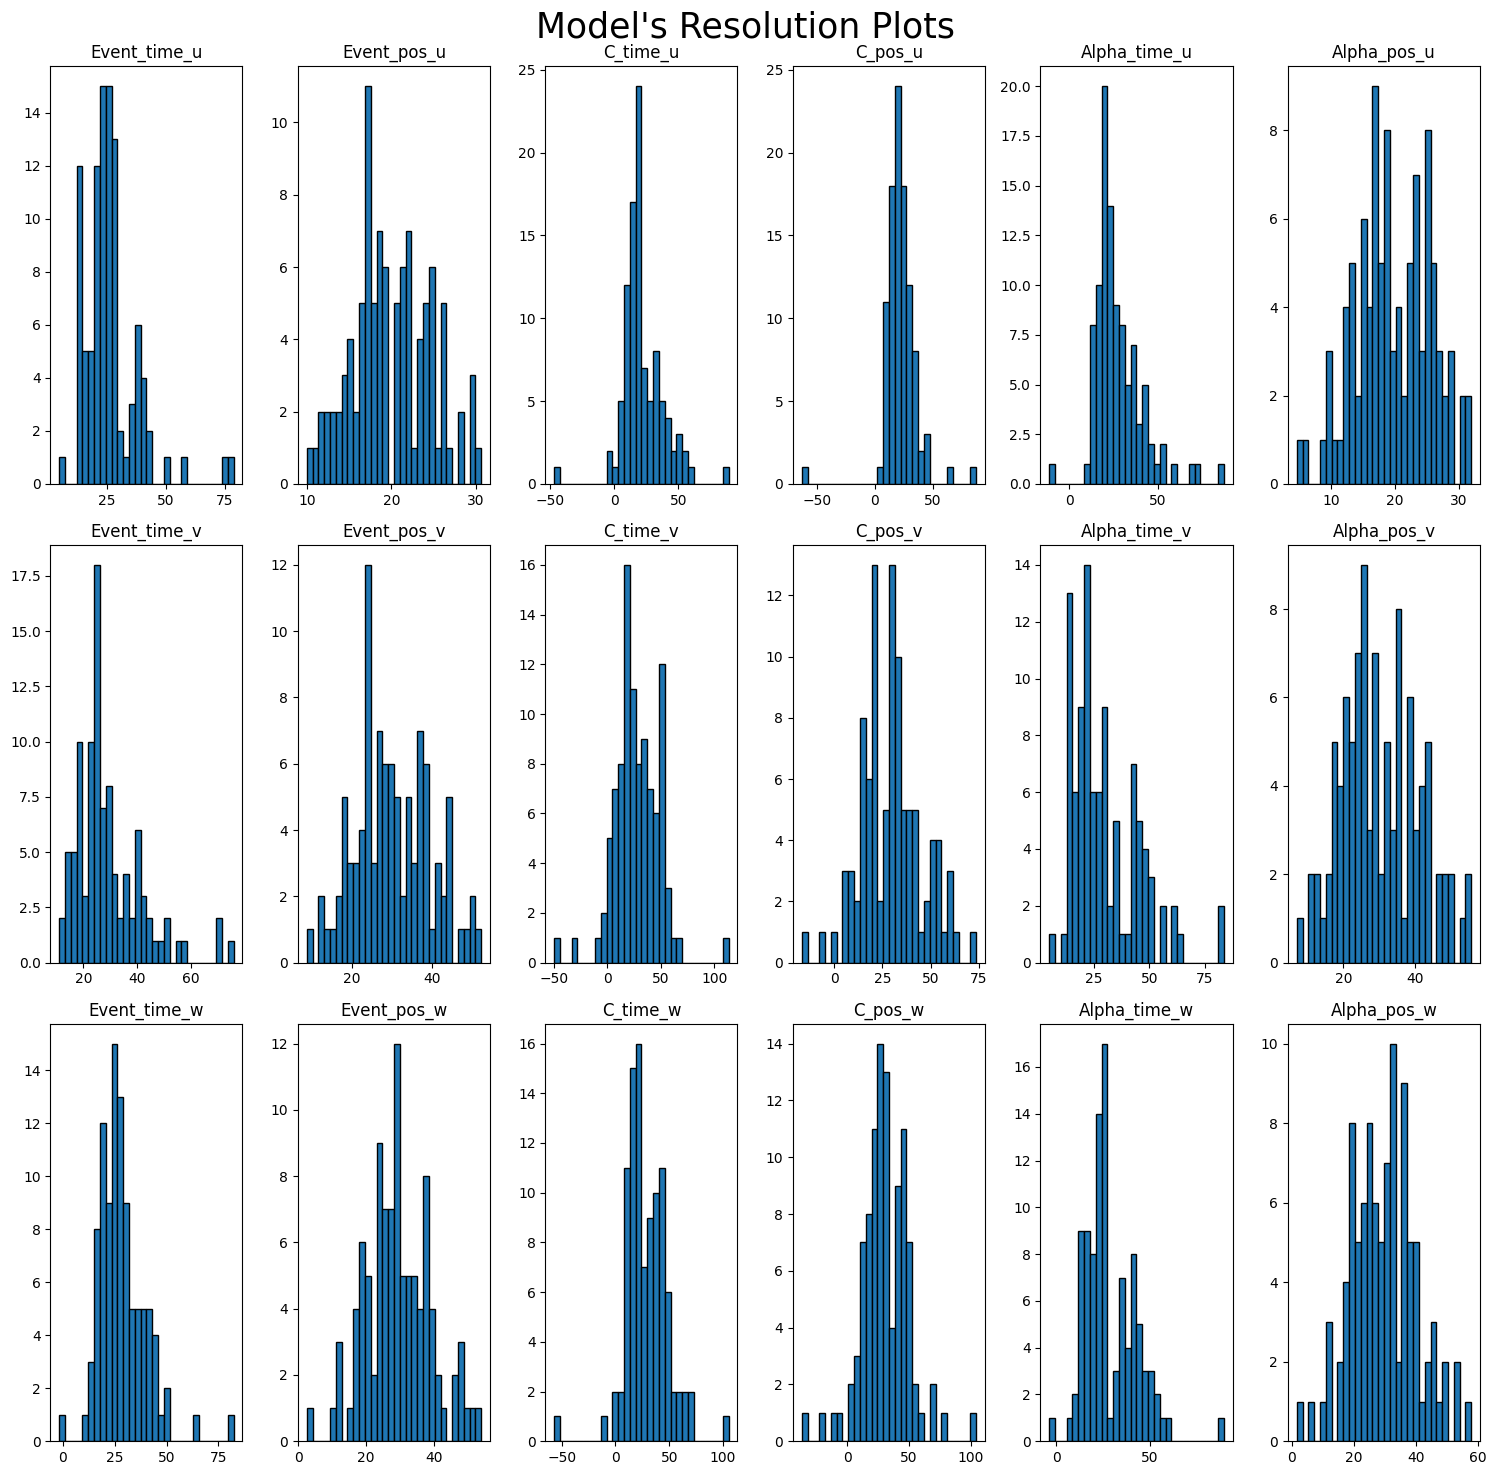

In [8]:
columns = ['Event_time_', 'Event_pos_', 'C_time_', 'C_pos_', 'Alpha_time_', 'Alpha_pos_']
names = ['u', 'v', 'w']

fig, axs = plt.subplots(len(names), len(columns), figsize=(15, 15))

plt.suptitle("Model's Resolution Plots", fontsize=25)
for i, name in enumerate(names):
    for j, column in enumerate(columns):
        differences = df_real[column+name] - df_predicted[column+name]

        axs[i, j].hist(differences, bins=30, edgecolor='black')
        axs[i, j].set_title(f'{column+name}')

plt.tight_layout()
plt.show()